In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from FDTDStaggered3D_with_relaxation.H5pySimple import ReadFromH5py,SaveToH5py
from FDTDStaggered3D_with_relaxation.PropagationModel import PropagationModel

PModel=PropagationModel()


StaggeredFDTD_3D_CUDA NOT loaded
StaggeredFDTD_3D_OPENCL loaded


### Preamble
Please consult first the example in the `1 - Flat source homgenous medium.ipynb` notebook for the basics how to run a simulation


In this example we will cover the importance and flexibility of specifying the directivity of the particle displacement in the source


# 1 - Source oriented in $Z$ direction
We repeat the simulation as in `1 - Flat source homgenous medium.ipynb` example

In [82]:
Frequency = 350e3  # Hz
MediumSOS = 1500 # m/s - water
MediumDensity=1000 # kg/m3

ShortestWavelength =MediumSOS / Frequency
SpatialStep =ShortestWavelength / 8.0 # A minimal step of 6 is recommnded

DimDomain =  np.array([0.05,0.05,0.1])  # in m, x,y,z

TxDiam = 0.03 # m, ciruclar piston
TxPlaneLocation = 0.01  # m , in XY plane at Z = 0.01 m

PMLThickness = 12 # grid points for perect matching layer, HIGHLY RECOMMENDED DO NOT CHANGE THIS SIZE 
ReflectionLimit= 1.0000e-05 #reflection parameter for PML, IGHLY RECOMMENDED DO NOT CHANGE THIS VALUE

N1=int(np.ceil(DimDomain[0]/SpatialStep)+2*PMLThickness)
N2=int(np.ceil(DimDomain[1]/SpatialStep)+2*PMLThickness)
N3=int(np.ceil(DimDomain[2]/SpatialStep)+2*PMLThickness)
print('Domain size',N1,N2,N3)
TimeSimulation=np.sqrt(DimDomain[0]**2+DimDomain[1]**2+DimDomain[2]**2)/MediumSOS #time to cross one corner to another
TemporalStep=1e-7 # if this step is too coarse a warning will be generated (but simulation will continue,) 

MaterialMap=np.zeros((N1,N2,N3),np.uint32) # note the 32 bit size
MaterialList=np.zeros((1,5)) # one material in this examples
MaterialList[0,0]=MediumDensity # water density
MaterialList[0,1]=MediumSOS # water SoS
#all other parameters are set to 0 


Domain size 118 118 211


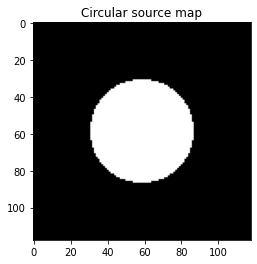

In [83]:
def MakeCircularSource(DimX,DimY,SpatialStep,Diameter):
    #simple defintion of a circular source centred in the domain
    XDim=np.arange(DimX)*SpatialStep
    YDim=np.arange(DimY)*SpatialStep
    XDim-=XDim.mean()
    YDim-=YDim.mean()
    XX,YY=np.meshgrid(XDim,YDim)
    MaskSource=(XX**2+YY**2)<=(Diameter/2.0)**2
    return (MaskSource*1.0).astype(np.uint32)

SourceMask=MakeCircularSource(N1,N2,SpatialStep,TxDiam)
plt.imshow(SourceMask,cmap=plt.cm.gray);
plt.title('Circular source map')

SourceMap=np.zeros((N1,N2,N3),np.uint32)
LocZ=int(np.round(TxPlaneLocation/SpatialStep))+PMLThickness
SourceMap[:,:,LocZ]=SourceMask 

Ox=np.zeros((N1,N2,N3))
Oy=np.zeros((N1,N2,N3))
Oz=np.zeros((N1,N2,N3))
Oz[SourceMap>0]=1 #only Z has a value of 1

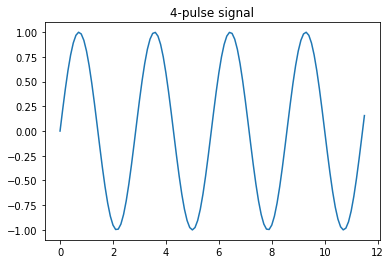

In [84]:


LengthSource=4.0/Frequency #we will use 4 pulses
TimeVectorSource=np.arange(0,LengthSource+TemporalStep,TemporalStep)

PulseSource = np.sin(2*np.pi*Frequency*TimeVectorSource)
plt.figure()
plt.plot(TimeVectorSource*1e6,PulseSource)
plt.title('4-pulse signal')

#note we need expressively to arrange the data in a 2D array
PulseSource=np.reshape(PulseSource,(1,len(TimeVectorSource))) 

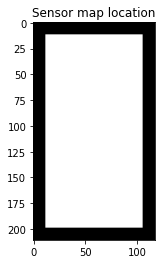

In [85]:
SensorMap=np.zeros((N1,N2,N3),np.uint32)

SensorMap[PMLThickness:-PMLThickness,int(N2/2),PMLThickness:-PMLThickness]=1

plt.figure()
plt.imshow(SensorMap[:,int(N2/2),:].T,cmap=plt.cm.gray)
plt.title('Sensor map location');

In [86]:
Sensor,LastMap,RMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         Ox,
                                                         Oy,
                                                         Oz,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=2,
                                                         USE_SINGLE=True,
                                                         DT=TemporalStep,
                                                         QfactorCorrection=True,
                                                         DefaultGPUDeviceName='Radeon',
                                                         TypeSource=1)

VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
VLongMat,VShearMat [1500.] [0.]
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 1.749724795401213e-07 [1500.] [0.] [0.] [0.] [4.54728409e-07] [1500.] [0.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1e-07 1.749724795401213e-07
Matrix size= 118 x 118 x 211 , spatial resolution = 0.000535714, time steps = 817, temporal step = 1e-07, total sonication length 8.16497e-05 
Performing Simulation wtih GPU OPENCL
Copying opencl files from /Users/spichardo/.edm/envs/MORPHEUS36/include/python3.6m/FDTDStaggered3D-with-relaxation/ to /Users/spichardo/Documents/GitHub/FDTDStaggered3D_with_relaxation/Example Notebooks
Running with new interface conditions
SizePML=1285633
SizePMLxp1=1310531
SizePMLyp1=1310531
SizePMLzp1=1299557
SizePMLxp1yp1zp1=1349801
 Staggered FDTD - compiled at Dec 27 2020 - 18:34:07
N1, N2,N3 , ZoneCount and D

### Ploting data

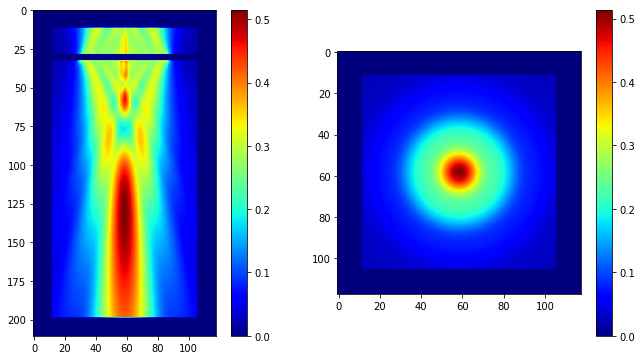

In [88]:
RMSValue[:,:,LocZ-2:LocZ+2]=0 # we hide the values too close to the source 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(RMSValue[:,int(N2/2),:].T,cmap=plt.cm.jet)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(RMSValue[:,:,125].T,cmap=plt.cm.jet)
plt.colorbar()

We calculate now peak and RMS values from

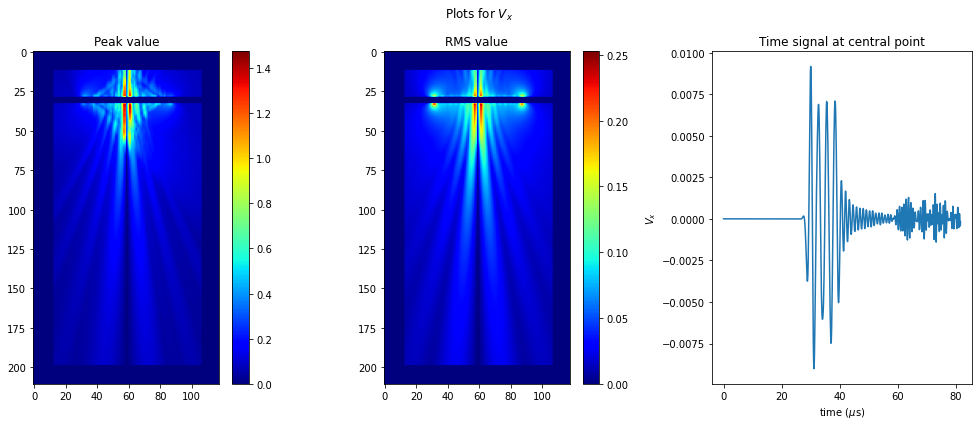

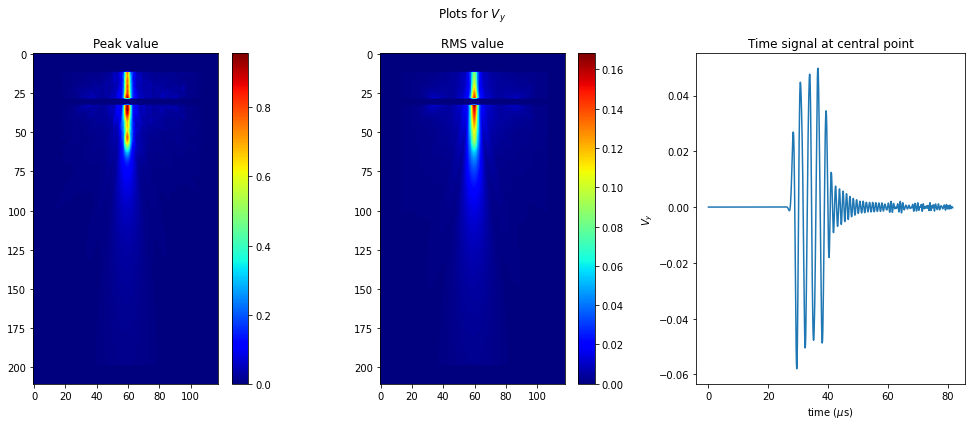

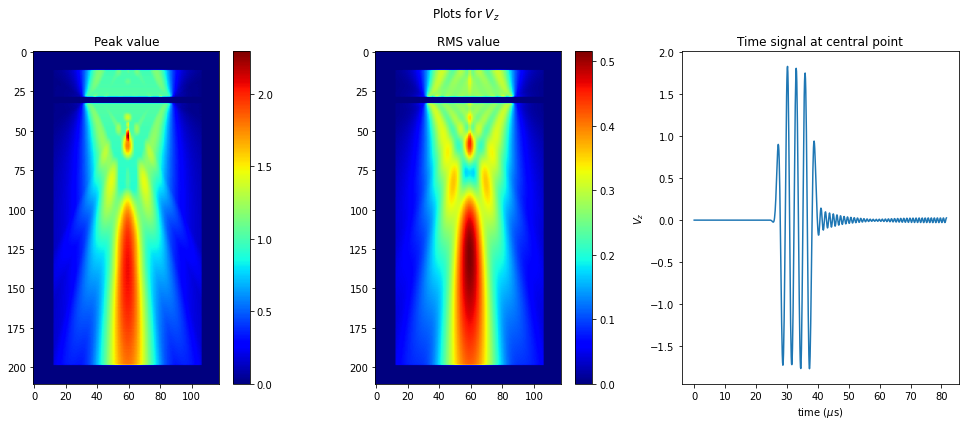

In [89]:
#To remain compatible with Matlab (whcih uses a Fortran convention for arrays, the index need to be rebuilt)
MaxSensorPlane=np.zeros((N1,N3))
RMSSensorPlane=np.zeros((N1,N3))

for s in ['Vx','Vy','Vz']:
    #We use the IndexSensorMap array that was used in the low level function to 
    for n, index in enumerate( InputParam['IndexSensorMap']): 
        k=int(index/(N1*N2))
        j=int(index%(N1*N2))
        i=int(j%N1)
        j=int(j/N1)
        assert(j==N2/2) #all way up we specified the XZ plane at N2/2, this assert should pass
        if i==int(N1/2) and k==int(N3/2):
            CentralPoint=n #we save this to later plot the time signal at the center
        MaxSensorPlane[i,k]=np.max(Sensor[s][n,:])
        RMSSensorPlane[i,k]=np.sqrt(1./len(Sensor[s][n,:])*np.sum(Sensor[s][n,:]**2))
    MaxSensorPlane[:,LocZ-2:LocZ+2]=0
    RMSSensorPlane[:,LocZ-2:LocZ+2]=0

    plt.figure(figsize=(14,6))
    plt.subplot(1,3,1)
    plt.imshow(MaxSensorPlane.T,cmap=plt.cm.jet)
    plt.title('Peak value')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(RMSSensorPlane.T,cmap=plt.cm.jet)
    plt.title('RMS value')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.plot(Sensor['time']*1e6,Sensor[s][CentralPoint])
    plt.xlabel('time ($\mu$s)')
    plt.ylabel('$'+s[0]+'_'+s[1]+'$')
    plt.title('Time signal at central point')
    plt.suptitle('Plots for $'+s[0]+'_'+s[1]+'$')
    plt.tight_layout()


## 1.a - Changing particle direction in previous example - bad direction
For purposes of illustration, we will change the particle displacmentdirection to $Y$. For many cases, this would be for the most an *erroneous* setting. We will repeat the simulation with all the other parameters as before.

In [90]:
BadOx=np.zeros((N1,N2,N3))
BadOy=np.zeros((N1,N2,N3))
BadOz=np.zeros((N1,N2,N3))
BadOy[SourceMap>0]=1 #only Y has a value of 1

In [91]:
Sensor,LastMap,RMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         BadOx, #We use now the wrong directivity
                                                         BadOy, #We use now the wrong directivity
                                                         BadOz, #We use now the wrong directivity
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=2,
                                                         USE_SINGLE=True,
                                                         DT=TemporalStep,
                                                         QfactorCorrection=True,
                                                         DefaultGPUDeviceName='Radeon',
                                                         TypeSource=1)

VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
VLongMat,VShearMat [1500.] [0.]
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 1.749724795401213e-07 [1500.] [0.] [0.] [0.] [4.54728409e-07] [1500.] [0.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1e-07 1.749724795401213e-07
Matrix size= 118 x 118 x 211 , spatial resolution = 0.000535714, time steps = 817, temporal step = 1e-07, total sonication length 8.16497e-05 
Performing Simulation wtih GPU OPENCL
Copying opencl files from /Users/spichardo/.edm/envs/MORPHEUS36/include/python3.6m/FDTDStaggered3D-with-relaxation/ to /Users/spichardo/Documents/GitHub/FDTDStaggered3D_with_relaxation/Example Notebooks
Running with new interface conditions
SizePML=1285633
SizePMLxp1=1310531
SizePMLyp1=1310531
SizePMLzp1=1299557
SizePMLxp1yp1zp1=1349801
 Staggered FDTD - compiled at Dec 27 2020 - 18:34:07
N1, N2,N3 , ZoneCount and D

### Ploting data

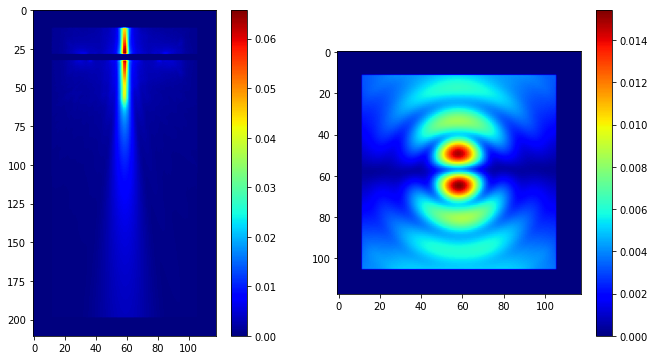

In [93]:
RMSValue[:,:,LocZ-2:LocZ+2]=0 # we hide the values too close to the source 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(RMSValue[:,int(N2/2),:].T,cmap=plt.cm.jet)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(RMSValue[:,:,125].T,cmap=plt.cm.jet)
plt.colorbar();

We calculate now peak and RMS values from sensor data

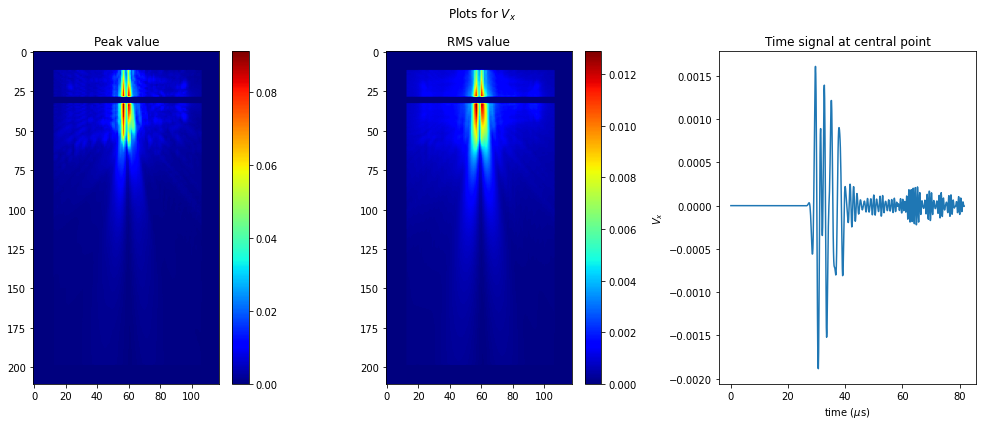

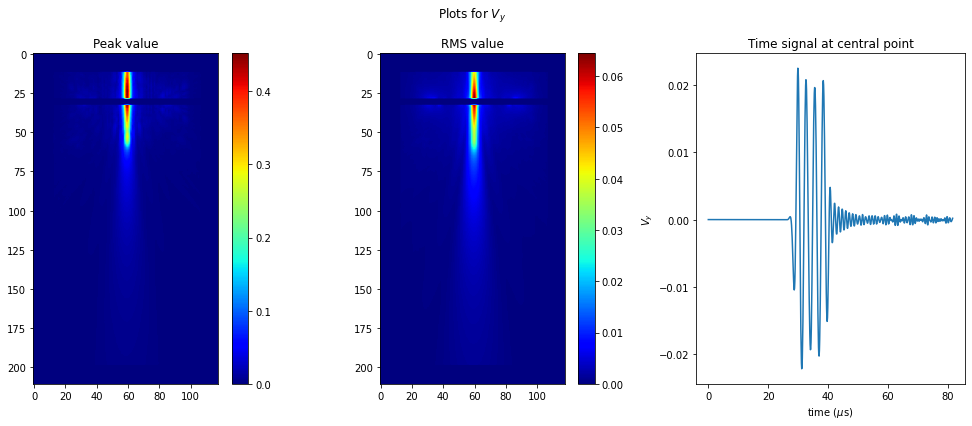

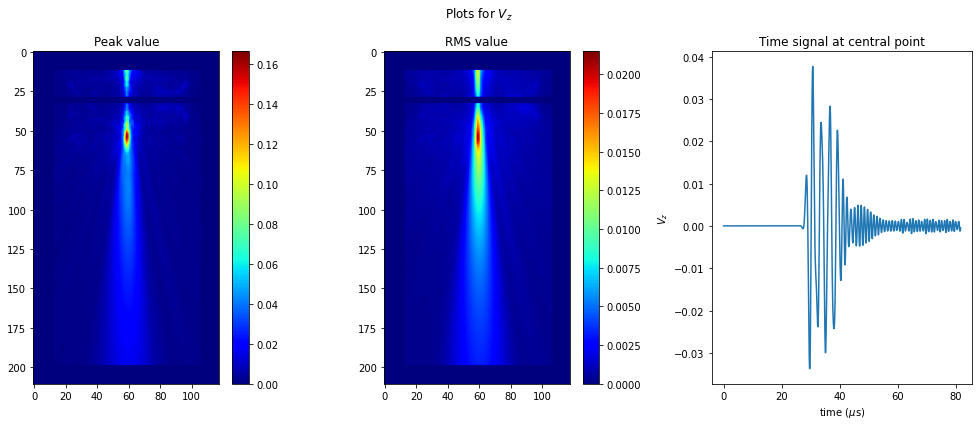

In [94]:
#To remain compatible with Matlab (whcih uses a Fortran convention for arrays, the index need to be rebuilt)
MaxSensorPlane=np.zeros((N1,N3))
RMSSensorPlane=np.zeros((N1,N3))

for s in ['Vx','Vy','Vz']:
    #We use the IndexSensorMap array that was used in the low level function to 
    for n, index in enumerate( InputParam['IndexSensorMap']): 
        k=int(index/(N1*N2))
        j=int(index%(N1*N2))
        i=int(j%N1)
        j=int(j/N1)
        assert(j==N2/2) #all way up we specified the XZ plane at N2/2, this assert should pass
        if i==int(N1/2) and k==int(N3/2):
            CentralPoint=n #we save this to later plot the time signal at the center
        MaxSensorPlane[i,k]=np.max(Sensor[s][n,:])
        RMSSensorPlane[i,k]=np.sqrt(1./len(Sensor[s][n,:])*np.sum(Sensor[s][n,:]**2))
    MaxSensorPlane[:,LocZ-2:LocZ+2]=0
    RMSSensorPlane[:,LocZ-2:LocZ+2]=0

    plt.figure(figsize=(14,6))
    plt.subplot(1,3,1)
    plt.imshow(MaxSensorPlane.T,cmap=plt.cm.jet)
    plt.title('Peak value')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(RMSSensorPlane.T,cmap=plt.cm.jet)
    plt.title('RMS value')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.plot(Sensor['time']*1e6,Sensor[s][CentralPoint])
    plt.xlabel('time ($\mu$s)')
    plt.ylabel('$'+s[0]+'_'+s[1]+'$')
    plt.title('Time signal at central point')
    plt.suptitle('Plots for $'+s[0]+'_'+s[1]+'$')
    plt.tight_layout()


-----
We can clearly see this field was not as intended to model an flat circular source

# 2 - Rotated source
We will now rotate the source 45 degrees. We will need to increase a bit the domain size.

In [95]:
DimDomain =  np.array([0.08,0.05,0.08])  # in m, x,y,z

TxDiam = 0.03 # m, ciruclar piston
TxPlaneLocation = 0.01  # m , in XY plane at Z = 0.01 m

PMLThickness = 12 # grid points for perect matching layer, HIGHLY RECOMMENDED DO NOT CHANGE THIS SIZE 
ReflectionLimit= 1.0000e-05 #reflection parameter for PML, IGHLY RECOMMENDED DO NOT CHANGE THIS VALUE

N1=int(np.ceil(DimDomain[0]/SpatialStep)+2*PMLThickness)
N2=int(np.ceil(DimDomain[1]/SpatialStep)+2*PMLThickness)
N3=int(np.ceil(DimDomain[2]/SpatialStep)+2*PMLThickness)
print('Domain size',N1,N2,N3)
TimeSimulation=np.sqrt(DimDomain[0]**2+DimDomain[1]**2+DimDomain[2]**2)/MediumSOS #time to cross one corner to another
TemporalStep=1e-7 # if this step is too coarse a warning will be generated (but simulation will continue,) 

MaterialMap=np.zeros((N1,N2,N3),np.uint32) # note the 32 bit size
MaterialList=np.zeros((1,5)) # one material in this examples
MaterialList[0,0]=MediumDensity # water density
MaterialList[0,1]=MediumSOS # water SoS
#all other parameters are set to 0 

Domain size 174 118 174


2472

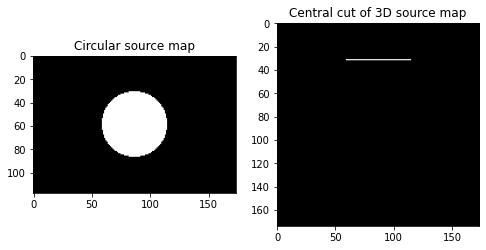

In [150]:
SourceMask=MakeCircularSource(N1,N2,SpatialStep,TxDiam).T
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.imshow(SourceMask.T,cmap=plt.cm.gray);
plt.title('Circular source map')

SourceMap=np.zeros((N1,N2,N3),np.uint32) #note this time we will use float type, later we will convert it back to uint32
LocZ=int(np.round(TxPlaneLocation/SpatialStep))+PMLThickness
SourceMap[:,:,LocZ]=SourceMask 

plt.subplot(1,2,2)
plt.imshow(SourceMap[:,int(N2/2),:].T,cmap=plt.cm.gray);
plt.title('Central cut of 3D source map');
np.sum(SourceMap)

We will rotate plane by plane using OpenCV

In [151]:
import cv2
from scipy import ndimage
def rotate_image(image, angle,shiftLR=0,shiftUP=0):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_NEAREST)
    result=np.roll(result,shiftUP,axis=1)
    result=np.roll(result,shiftLR,axis=0)
    return result

3484

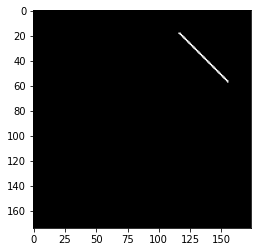

In [152]:
for n in range(N2):
    #SourceMap[:,n,:]=rotate_image(SourceMap[:,n,:],45,10,-10)
    SourceMap[:,n,:]=np.roll(np.roll(ndimage.rotate(SourceMap[:,n,:],45,mode='nearest',reshape=False),-10,axis=1),10,axis=0)
SourceMap=SourceMap.astype(np.uint32) # We put it back to unit32
plt.imshow(SourceMap[:,int(N2/2),:].T,cmap=plt.cm.gray);
np.sum(SourceMap)

Now we just create a vector for the particle displacement oriented in the right direction

In [153]:
Ox=np.zeros((N1,N2,N3))
Oy=np.zeros((N1,N2,N3))
Oz=np.zeros((N1,N2,N3))
Vector45XZ=[-1,0,1]
Vector45XZ/=np.linalg.norm(Vector45XZ)
print('Vector45XZ',Vector45XZ)
Ox[SourceMap>0]=Vector45XZ[0]
Oy[SourceMap>0]=Vector45XZ[1]
Oz[SourceMap>0]=Vector45XZ[2]

Vector45XZ [-0.70710678  0.          0.70710678]


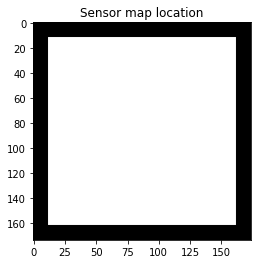

In [154]:
SensorMap=np.zeros((N1,N2,N3),np.uint32)

SensorMap[PMLThickness:-PMLThickness,int(N2/2),PMLThickness:-PMLThickness]=1

plt.figure()
plt.imshow(SensorMap[:,int(N2/2),:].T,cmap=plt.cm.gray)
plt.title('Sensor map location');

In [155]:
Sensor,LastMap,RMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         Ox,
                                                         Oy,
                                                         Oz,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=2,
                                                         USE_SINGLE=True,
                                                         DT=TemporalStep,
                                                         QfactorCorrection=True,
                                                         DefaultGPUDeviceName='Radeon',
                                                         TypeSource=1)

VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
VLongMat,VShearMat [1500.] [0.]
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 1.749724795401213e-07 [1500.] [0.] [0.] [0.] [4.54728409e-07] [1500.] [0.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1e-07 1.749724795401213e-07
Matrix size= 174 x 118 x 174 , spatial resolution = 0.000535714, time steps = 825, temporal step = 1e-07, total sonication length 8.24621e-05 
Performing Simulation wtih GPU OPENCL
Copying opencl files from /Users/spichardo/.edm/envs/MORPHEUS36/include/python3.6m/FDTDStaggered3D-with-relaxation/ to /Users/spichardo/Documents/GitHub/FDTDStaggered3D_with_relaxation/Example Notebooks
Running with new interface conditions
SizePML=1457569
SizePMLxp1=1478101
SizePMLyp1=1487845
SizePMLzp1=1478101
SizePMLxp1yp1zp1=1529376
 Staggered FDTD - compiled at Dec 27 2020 - 18:34:07
N1, N2,N3 , ZoneCount and D

### Ploting data

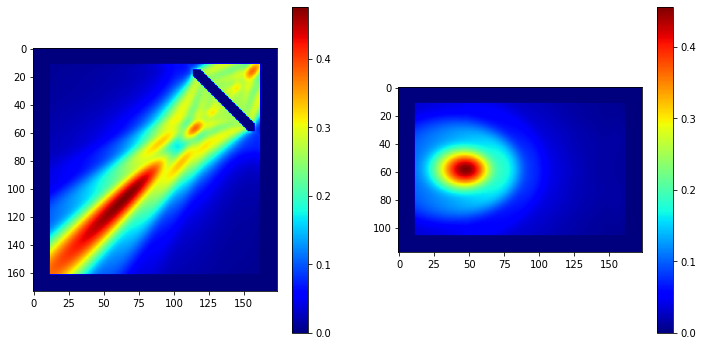

In [156]:
for n in range(-2,3):
    for m in range(-2,3):
        RMSValue[np.roll(np.roll(SourceMap>0,n,axis=0),m,axis=2)]=0. #we turn off the values close the source 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(RMSValue[:,int(N2/2),:].T,cmap=plt.cm.jet)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(RMSValue[:,:,125].T,cmap=plt.cm.jet)
plt.colorbar();

We can see a similar acoustic field as the first test above , just rotated 45 degrees.

We can see now the individual vector components of the displacements

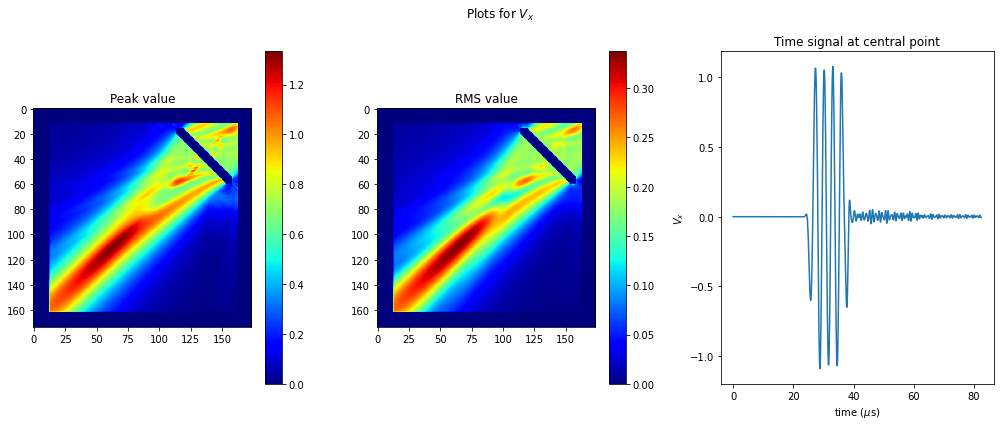

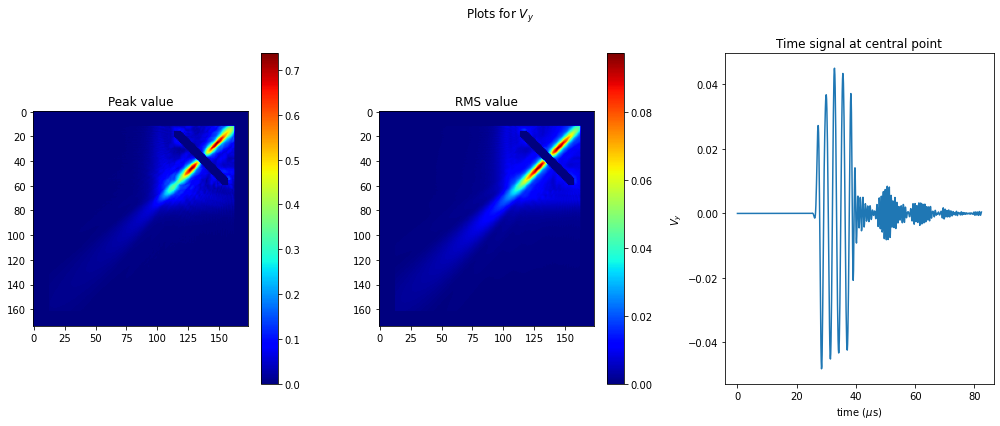

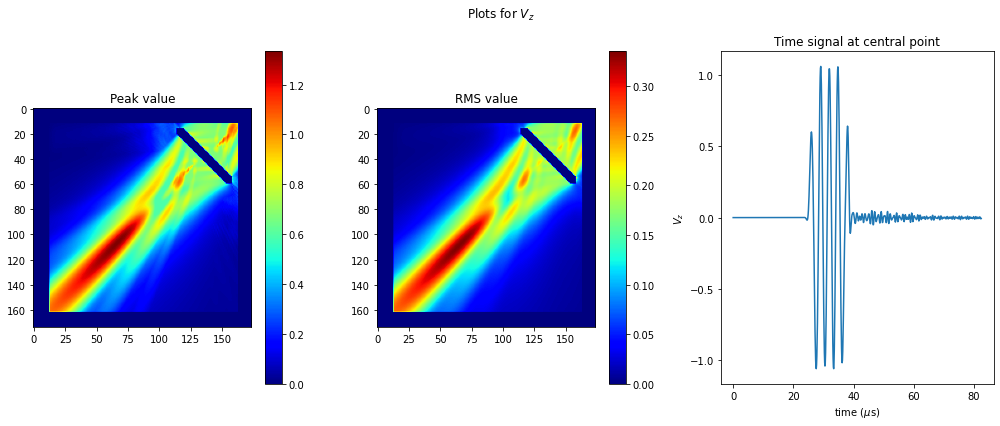

In [158]:
#To remain compatible with Matlab (whcih uses a Fortran convention for arrays, the index need to be rebuilt)
MaxSensorPlane=np.zeros((N1,N3))
RMSSensorPlane=np.zeros((N1,N3))

for s in ['Vx','Vy','Vz']:
    #We use the IndexSensorMap array that was used in the low level function to 
    for n, index in enumerate( InputParam['IndexSensorMap']): 
        k=int(index/(N1*N2))
        j=int(index%(N1*N2))
        i=int(j%N1)
        j=int(j/N1)
        assert(j==N2/2) #all way up we specified the XZ plane at N2/2, this assert should pass
        if i==int(N1/2) and k==int(N3/2):
            CentralPoint=n #we save this to later plot the time signal at the center
        MaxSensorPlane[i,k]=np.max(Sensor[s][n,:])
        RMSSensorPlane[i,k]=np.sqrt(1./len(Sensor[s][n,:])*np.sum(Sensor[s][n,:]**2))
        
    for n in range(-2,3):
        for m in range(-2,3):
            MaxSensorPlane[np.roll(np.roll(SourceMap[:,j,:]>0,n,axis=0),m,axis=1)]=0. 
            RMSSensorPlane[np.roll(np.roll(SourceMap[:,j,:]>0,n,axis=0),m,axis=1)]=0.

    plt.figure(figsize=(14,6))
    plt.subplot(1,3,1)
    plt.imshow(MaxSensorPlane.T,cmap=plt.cm.jet)
    plt.title('Peak value')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(RMSSensorPlane.T,cmap=plt.cm.jet)
    plt.title('RMS value')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.plot(Sensor['time']*1e6,Sensor[s][CentralPoint])
    plt.xlabel('time ($\mu$s)')
    plt.ylabel('$'+s[0]+'_'+s[1]+'$')
    plt.title('Time signal at central point')
    plt.suptitle('Plots for $'+s[0]+'_'+s[1]+'$')
    plt.tight_layout()


We can see now how the field is split mainly in X and Z components

### 2.a - Assigning again  bad direction
We repeat the exercise of assigning a wrong orientation to the particles

In [159]:
BadOx=np.zeros((N1,N2,N3))
BadOy=np.zeros((N1,N2,N3))
BadOz=np.zeros((N1,N2,N3))
BadOy[SourceMap>0]=1 #only Y has a value of 1

In [160]:
SensorBad,LastMap,RMSValueBad,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         BadOx, #We use now the wrong directivity
                                                         BadOy, #We use now the wrong directivity
                                                         BadOz, #We use now the wrong directivity
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=2,
                                                         USE_SINGLE=True,
                                                         DT=TemporalStep,
                                                         QfactorCorrection=True,
                                                         DefaultGPUDeviceName='Radeon',
                                                         TypeSource=1)

VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
VLongMat,VShearMat [1500.] [0.]
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 1.749724795401213e-07 [1500.] [0.] [0.] [0.] [4.54728409e-07] [1500.] [0.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1e-07 1.749724795401213e-07
Matrix size= 174 x 118 x 174 , spatial resolution = 0.000535714, time steps = 825, temporal step = 1e-07, total sonication length 8.24621e-05 
Performing Simulation wtih GPU OPENCL
Copying opencl files from /Users/spichardo/.edm/envs/MORPHEUS36/include/python3.6m/FDTDStaggered3D-with-relaxation/ to /Users/spichardo/Documents/GitHub/FDTDStaggered3D_with_relaxation/Example Notebooks
Running with new interface conditions
SizePML=1457569
SizePMLxp1=1478101
SizePMLyp1=1487845
SizePMLzp1=1478101
SizePMLxp1yp1zp1=1529376
 Staggered FDTD - compiled at Dec 27 2020 - 18:34:07
N1, N2,N3 , ZoneCount and D

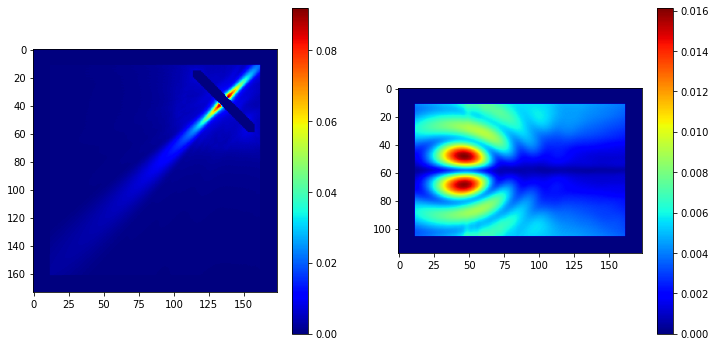

In [161]:
for n in range(-2,3):
    for m in range(-2,3):
        RMSValueBad[np.roll(np.roll(SourceMap>0,n,axis=0),m,axis=2)]=0. #we turn off the values close the source 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(RMSValueBad[:,int(N2/2),:].T,cmap=plt.cm.jet)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(RMSValueBad[:,:,125].T,cmap=plt.cm.jet)
plt.colorbar();

We can see again that the wrong assigment to the directivity produces an inacurate field

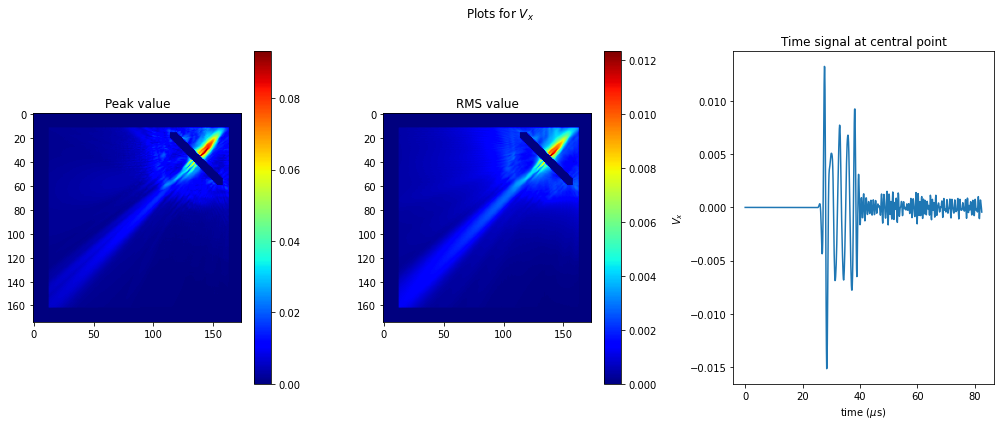

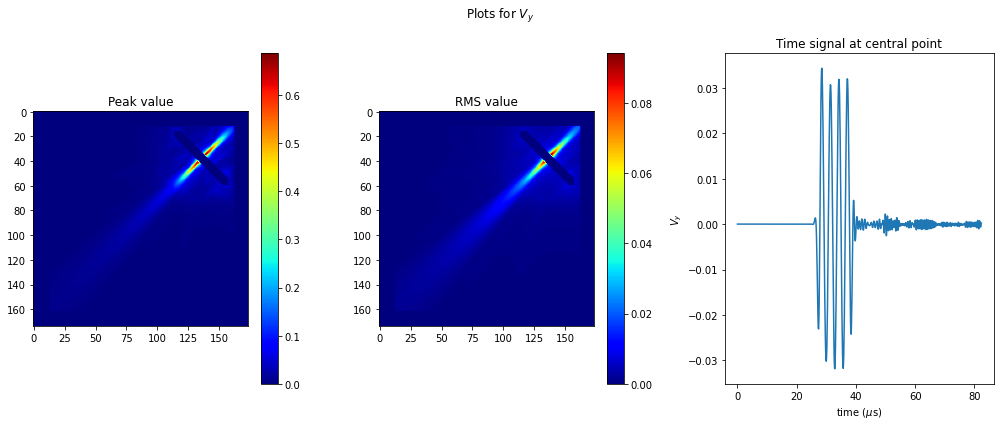

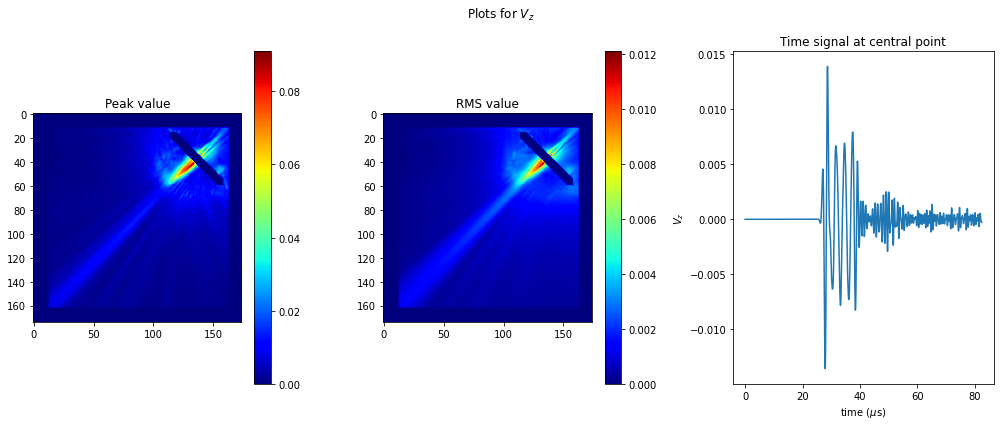

In [165]:
#To remain compatible with Matlab (whcih uses a Fortran convention for arrays, the index need to be rebuilt)
MaxSensorPlane=np.zeros((N1,N3))
RMSSensorPlane=np.zeros((N1,N3))

for s in ['Vx','Vy','Vz']:
    #We use the IndexSensorMap array that was used in the low level function to 
    for n, index in enumerate( InputParam['IndexSensorMap']): 
        k=int(index/(N1*N2))
        j=int(index%(N1*N2))
        i=int(j%N1)
        j=int(j/N1)
        assert(j==N2/2) #all way up we specified the XZ plane at N2/2, this assert should pass
        if i==int(N1/2) and k==int(N3/2):
            CentralPoint=n #we save this to later plot the time signal at the center
        MaxSensorPlane[i,k]=np.max(SensorBad[s][n,:])
        RMSSensorPlane[i,k]=np.sqrt(1./len(SensorBad[s][n,:])*np.sum(SensorBad[s][n,:]**2))
        
    for n in range(-2,3):
        for m in range(-2,3):
            MaxSensorPlane[np.roll(np.roll(SourceMap[:,j,:]>0,n,axis=0),m,axis=1)]=0. 
            RMSSensorPlane[np.roll(np.roll(SourceMap[:,j,:]>0,n,axis=0),m,axis=1)]=0.

    plt.figure(figsize=(14,6))
    plt.subplot(1,3,1)
    plt.imshow(MaxSensorPlane.T,cmap=plt.cm.jet)
    plt.title('Peak value')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(RMSSensorPlane.T,cmap=plt.cm.jet)
    plt.title('RMS value')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.plot(Sensor['time']*1e6,SensorBad[s][CentralPoint])
    plt.xlabel('time ($\mu$s)')
    plt.ylabel('$'+s[0]+'_'+s[1]+'$')
    plt.title('Time signal at central point')
    plt.suptitle('Plots for $'+s[0]+'_'+s[1]+'$')
    plt.tight_layout()
